# Module 12 Problem Set

This Problem Set covers *all 4* of the clustering algorithms discussed this week. Since this class is on Wednesday (no class this Friday!) I don't expect you to have seen today's lecture on Hierarchical Clustering yet - I go a bit more in depth about how it works in that section. 

Code presented in this Problem Set should be *quite* applicable to Homework 3.

In [1]:
import numpy as np
import pandas as pd

## Helpers

I'll start the notebook off with some helper functions for use later in the code. Each one contains a good number of comments and type hinting. **I strongly recommend using methods like these to make your code easier to read and follow better coding practice.** We will be taking off more points for code that does not follow best practice principles like using functions where appropriate on HW3.

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

def evaluate_clustering(y_true, y_pred, average='binary'):
    '''Function to help evaluate our clustering outputs later in the notebook.
    Takes as input the true and predicted labels for a given class and an optional 'average' keyword argument,
    and outputs a tuple of:
        - confusion matrix
        - accuracy score
        - f1 score
        - precision
        - recall
    '''
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return cm, accuracy, f1, precision, recall

Note that clustering algorithms are *unsupervised*. They do not require true labels to work, and we will not be passing them true labels to fit. These metrics are simply here to help us evaluate the differences among the algorithms we have in a more objective way, since our dataset does have labels. Some clustering algorithms will let us choose the number of clusters, and some will automatically choose it for us.

With that in mind (and looking at the documentation for `f1_score`, `precision_score`, and/or `recall_score`), **what is the purpose of the "average" keyword argument? In what cases might we pass that argument to the function rather than leaving it as binary?**

*[...]*

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title):
    '''Function to plot a confusion matrix from a numpy array and a plot title.'''
    plt.figure(figsize=(6, 6))
    # Heatmap scales colors based on size - the larger the number, the darker the color
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

*Note: because of the unsupervised nature of the clustering algorthms, the cluster assigned to the points is arbitrary (e.g. what we have as true label "0" could be put into cluster "1"). Through visualization and mindfulness, I address this problem when it happens in the problem set code*

In [4]:
def visualize_clustering(X, labels, title=None, cmap='coolwarm'):
    '''Visualization helper function for labels from a clustering algorithm that
        1) ensures that all the plots are the same colors (Blue/Orange: Go Gators!)
        2) Keeps class labels the same color (Class labeled 0 will always be 0).
    Assumes 2D feature space.
    '''
    for label in np.unique(labels):  
        # Subset our X where our label matches for both x (first feature) and y (second feature)
        # Colors will be assigned based on our label kwarg.
        plt.scatter(X[labels == label, 0], X[labels == label, 1], label=f"Class {label}", cmap=cmap)
    plt.title(title)

In [5]:
def plot_decision_boundary(model, X, labels, title=None, cmap=None):
    '''Plot the decision boundary for a model
    model: Predictor (must have a .predict method!!!!)
    X: input features (required to be 2 dimensional)
    labels: labels generated by clustering algorithm (required to be the same length as X)
    cmap: color mapping for plotting
    '''
    h = .02  # Step size in the mesh
    # Set the min and max values for our axes to be 1 higher than the max value and 1 lower than the min value
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Generate every point in the grid 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Horizontally concatenate 1D arrays into 2D array
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])  # .ravel() flattens the array as a view (memory efficient)
    Z = Z.reshape(xx.shape)                           # Ensure outputs are the same dimension
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.8)     # contourf: color 
    
    # Scatter plot for true labels
    for label in np.unique(labels):
        plt.scatter(X[labels == label, 0], X[labels == label, 1], label=f"Class {label}")
    
    plt.title(title)  

## Dataset

The dataset we are using for this code is the Breast Cancer Wisconsin dataset, a dataset we have used a few times in this class. I was yesterday years old when I learned that sklearn actually packages this dataset in the datasets submodule

### Loading and Information

In [6]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data
y = data.target

*Information source from [UCI ML Repo](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)*

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  They describe characteristics of the cell nuclei present in the image. A few of the images can be found at http://www.cs.wisc.edu/~street/images/

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree.  Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

### Feature Reduction

In [7]:
X.shape

(569, 30)

Our input data is 30-dimensional. The purpose of the code below is to *reduce* the number of dimensions down to something more understandable for us (something I can plot easily in the notebook). The code below uses something called Principle Component Analysis (PCA) to perform the dimensionality reduction to 2 dimensions. We will take a deep dive into how this is done next week and some other ways you can go about doing it, so I won't really touch on it too much.

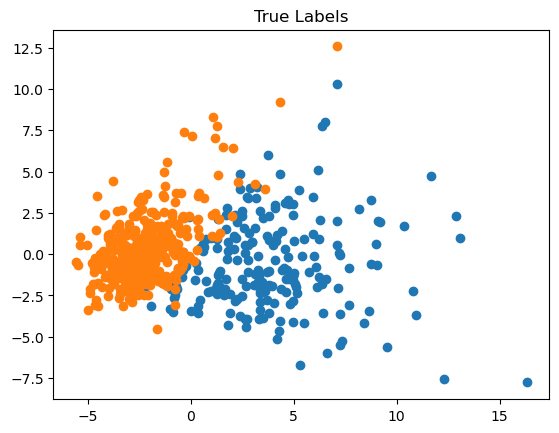

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce dimensionality
n_components = 2  # Set the number of components (adjustable)
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

visualize_clustering(X_pca, y, title='True Labels')

Importantly, after this cell is ran, our features are in the varaible `X_pca`.

In [9]:
X_pca.shape

(569, 2)

## K-means Clustering

In [10]:
from sklearn.cluster import KMeans
# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=3621)  # You can change the number of clusters
# We can use the fit_predict method to first fit, then predict all datapoints
kmeans_labels = kmeans.fit_predict(X_pca)  

**How did I choose a value for n_clusters? Why didn't I set it to 3 or 4?**

*[...]*

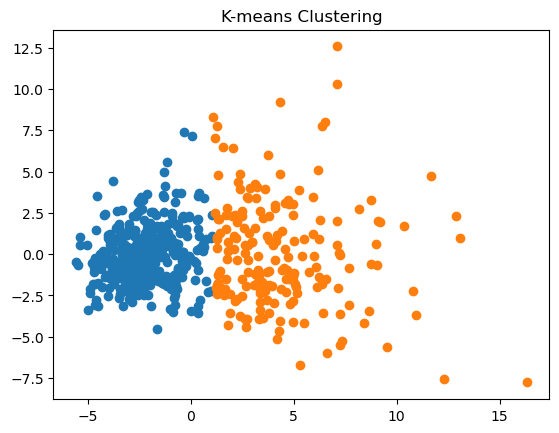

In [11]:
visualize_clustering(X_pca, kmeans_labels, title='K-means Clustering')

Recall that our helper function keeps the colors consistent between classes. Comparing this to our orignal array, we see that our data the opposite of what we want it to be. We can invert the array without loss of generality.

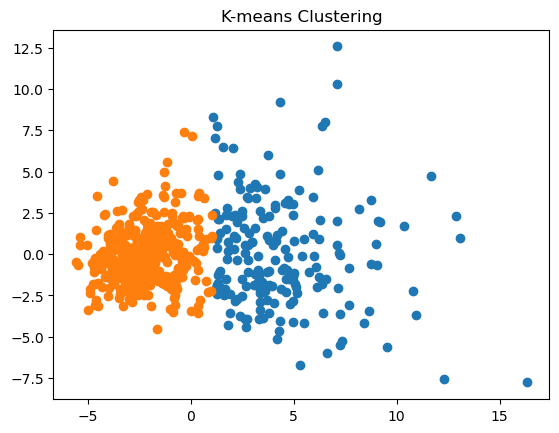

In [12]:
kmeans_labels = np.abs(1 - kmeans_labels)
visualize_clustering(X_pca, kmeans_labels, title='K-means Clustering')

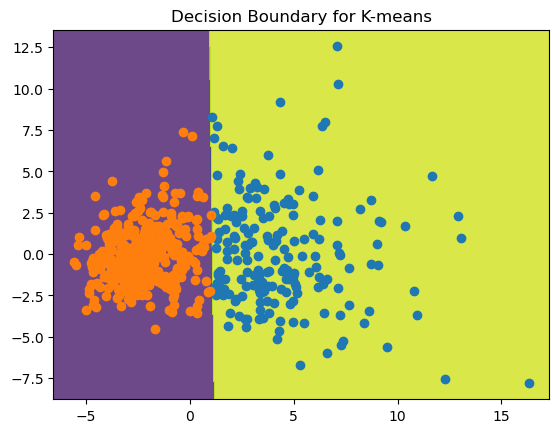

In [13]:
plot_decision_boundary(kmeans, X_pca, kmeans_labels, title='Decision Boundary for K-means')

**What is this chart showing us?** (Sorry for the ugly colors haha)

*[...]*

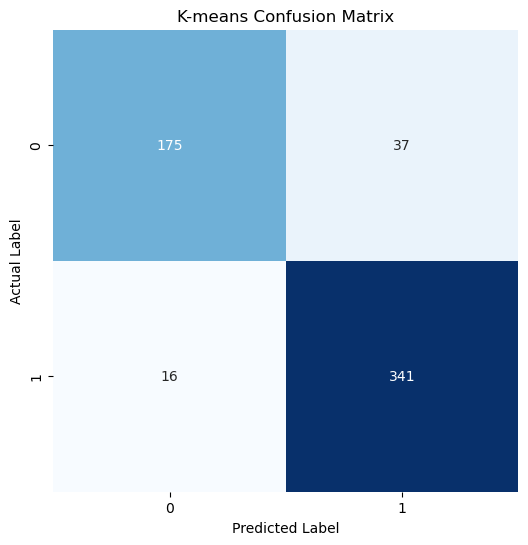

In [14]:
kmeans_cm, kmeans_accuracy, kmeans_f1, kmeans_precision, kmeans_recall = evaluate_clustering(y, kmeans_labels)

# We will use the following dictionary to keep track of our data as we generate it
metrics_data = {
    'K-means': [kmeans_accuracy, kmeans_f1, kmeans_precision, kmeans_recall]
}

plot_confusion_matrix(kmeans_cm, "K-means Confusion Matrix")

In [15]:
kmeans_accuracy

0.9068541300527241

**Provide some interpretaion for this number (accuracy score)**

*[...]*

We don't have a train/test split for our data - **is this okay? Is there data leakage? Why or why not?**

*[...]*

## K-medoids Clustering

**Apply K-medoids clustering, picking an appropriate number of clusters and a random seed for reproducibilty. Fit the data and make predictions.** Place your model in the variable `kmedoids` and your labels in the variable `kmedoids_labels`.

In [16]:
from sklearn_extra.cluster import KMedoids  # !pip install scikit-learn-extra

## CODE HERE

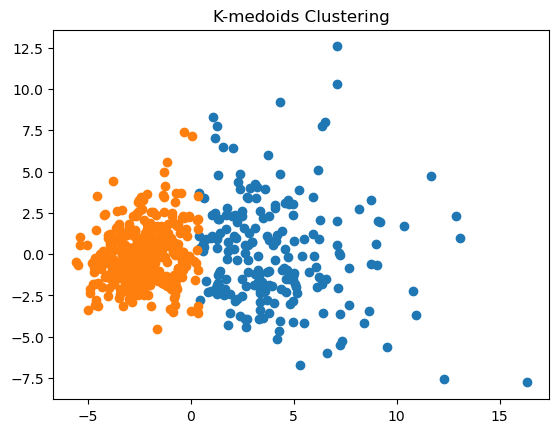

In [17]:
visualize_clustering(X_pca, kmedoids_labels, title='K-medoids Clustering')

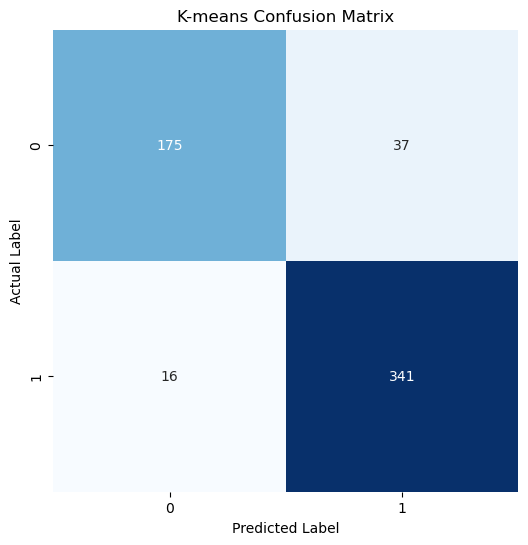

In [18]:
(kmedoids_cm, 
 kmedoids_accuracy, 
 kmedoids_f1, 
 kmedoids_precision, 
 kmedoids_recall) = evaluate_clustering(y, kmedoids_labels)

metrics_data['K-medoids'] = [kmedoids_accuracy, kmedoids_f1, kmedoids_precision, kmedoids_recall]

plot_confusion_matrix(kmeans_cm, "K-means Confusion Matrix")

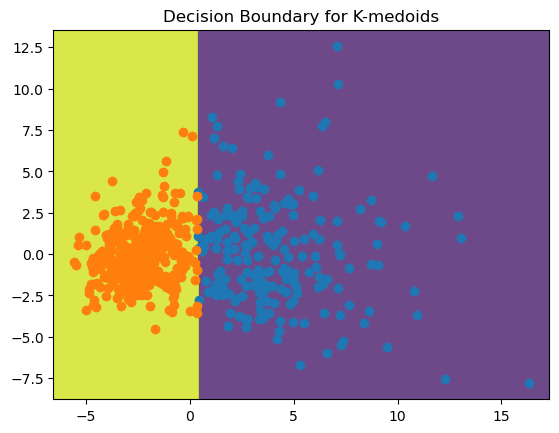

In [19]:
plot_decision_boundary(kmedoids, X_pca, kmedoids_labels, title='Decision Boundary for K-medoids')

In [20]:
kmedoids_f1

0.9346314325452015

**Provide some interpretaion for this number (F1 Score)**

*[...]*

## Mean Shift Clustering

In [21]:
from sklearn.cluster import MeanShift

mean_shift = MeanShift()
mean_shift_labels = mean_shift.fit_predict(X_pca)

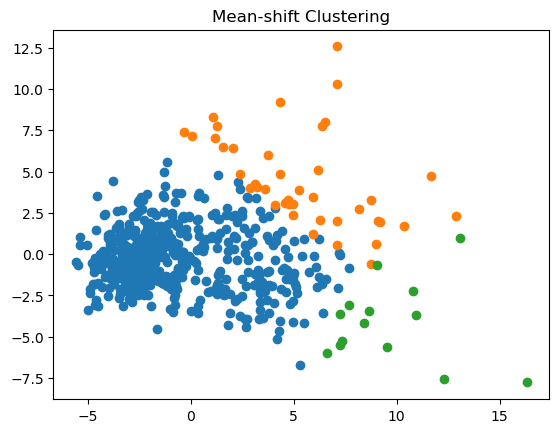

In [22]:
visualize_clustering(X_pca, mean_shift_labels, title='Mean-shift Clustering')

**Why is there a third color here? Can we specify the number of colors in our output?** In other words, can you explain from a higher level how mean-shift works?

*[...]*

Give the model the benefit of the doubt and switch class 0 and 1 here. We can't use the exact same code since we have 3 clusters.

In [23]:
mean_shift_labels = np.where(mean_shift_labels == 0, 1, np.where(mean_shift_labels == 1, 0, mean_shift_labels))

**Using the code examples previously and your knowledge about our model's clustering output, fill in the following line of code:**

In [24]:
(mean_shift_cm, 
 mean_shift_accuracy, 
 mean_shift_f1, 
 mean_shift_precision, 
 mean_shift_recall) = ### CODE HERE

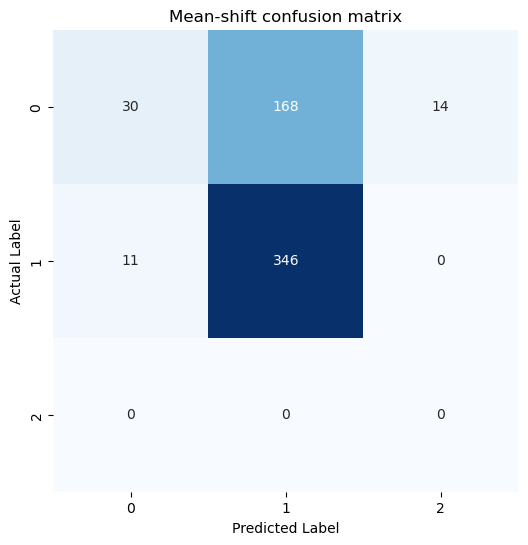

In [25]:
metrics_data['Mean-shift'] = [mean_shift_accuracy, mean_shift_f1, mean_shift_precision, mean_shift_recall]

plot_confusion_matrix(mean_shift_cm, title='Mean-shift confusion matrix')

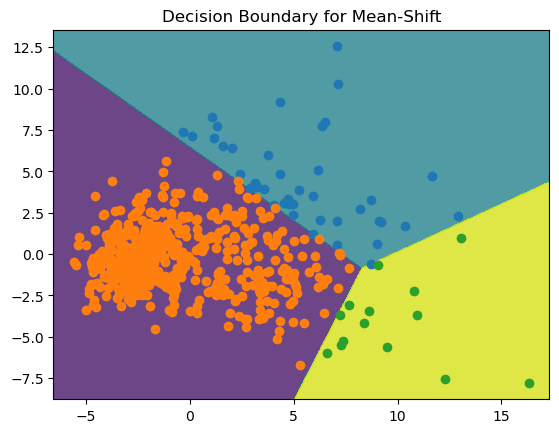

In [26]:
plot_decision_boundary(mean_shift, X_pca, mean_shift_labels, title='Decision Boundary for Mean-Shift')

In [27]:
mean_shift_precision

0.6608084358523726

**Provide some interpretaion for this number (Precision) in the context of binary classification.** In other words, assume that the value above is functionally the same as it would be in binary classification.

*[...]*

## Hierarchical Clustering

Hierarchical clustering algorithms are types of clustering algorithms that build a hierarchical structure of clusters. Each datapoint starts in its own cluster and then the algorithm merges clusters together until a termination condition is met (like only 2 clusters remain, or the size of any cluster is a certain number). They are normally represented using a dendrogram. Unlike K-means, it does not require a specific number of clusters to be known beforehand. However, unlike Mean-Shift, you *can* have a specific number of clusters beforehand.

In [28]:
from sklearn.cluster import AgglomerativeClustering

# You can change the number of clusters and hyperparameters like the linkage (default is ward to minimize)
#  variance between merged clusters. See docs for more options
agg_clustering = AgglomerativeClustering(n_clusters=2)  
agg_labels = agg_clustering.fit_predict(X_pca)

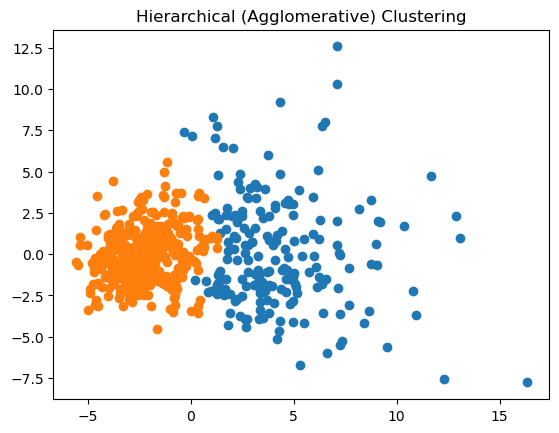

In [29]:
visualize_clustering(X_pca, agg_labels, title='Hierarchical (Agglomerative) Clustering')

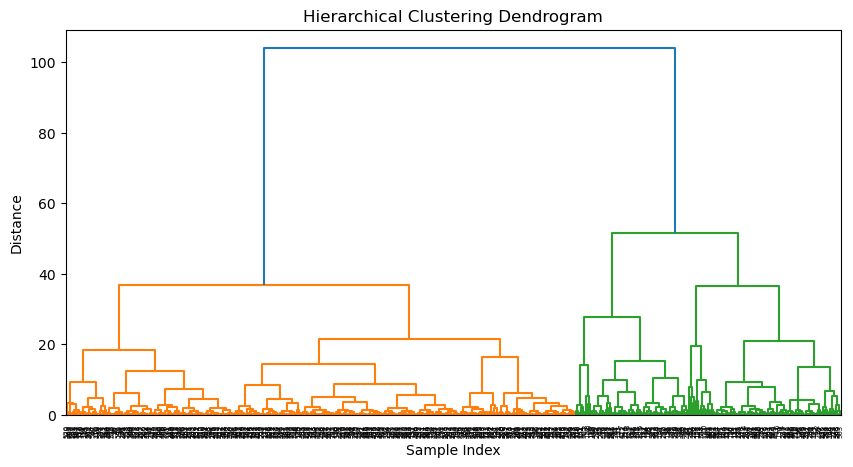

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering and obtain the linkage matrix
Z = linkage(X_pca, method='ward')  # Replace 'X_pca' with your data and method

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

**How can we use this dendrogram to visually see where the algorithm would have split the data into 3 clusters? What about 4?**

*[...]*

**We can't plot a decision boundary like we can for our previous models. Why not?**

 *[...]*

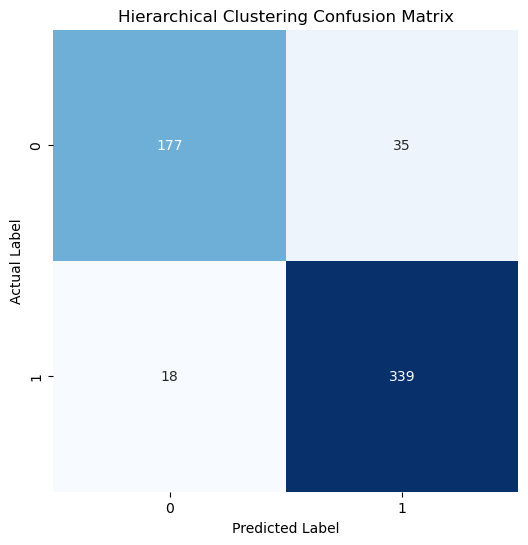

In [31]:
agg_cm, agg_accuracy, agg_f1, agg_precision, agg_recall = evaluate_clustering(y, agg_labels)

metrics_data['Hierarchical'] =[agg_accuracy, agg_f1, agg_precision, agg_recall]

plot_confusion_matrix(agg_cm, title='Hierarchical Clustering Confusion Matrix')

In [32]:
agg_recall

0.9495798319327731

One last time, **provide some interpretation for this number (Recall)**.

*[...]*

## Analysis

### Visualizations

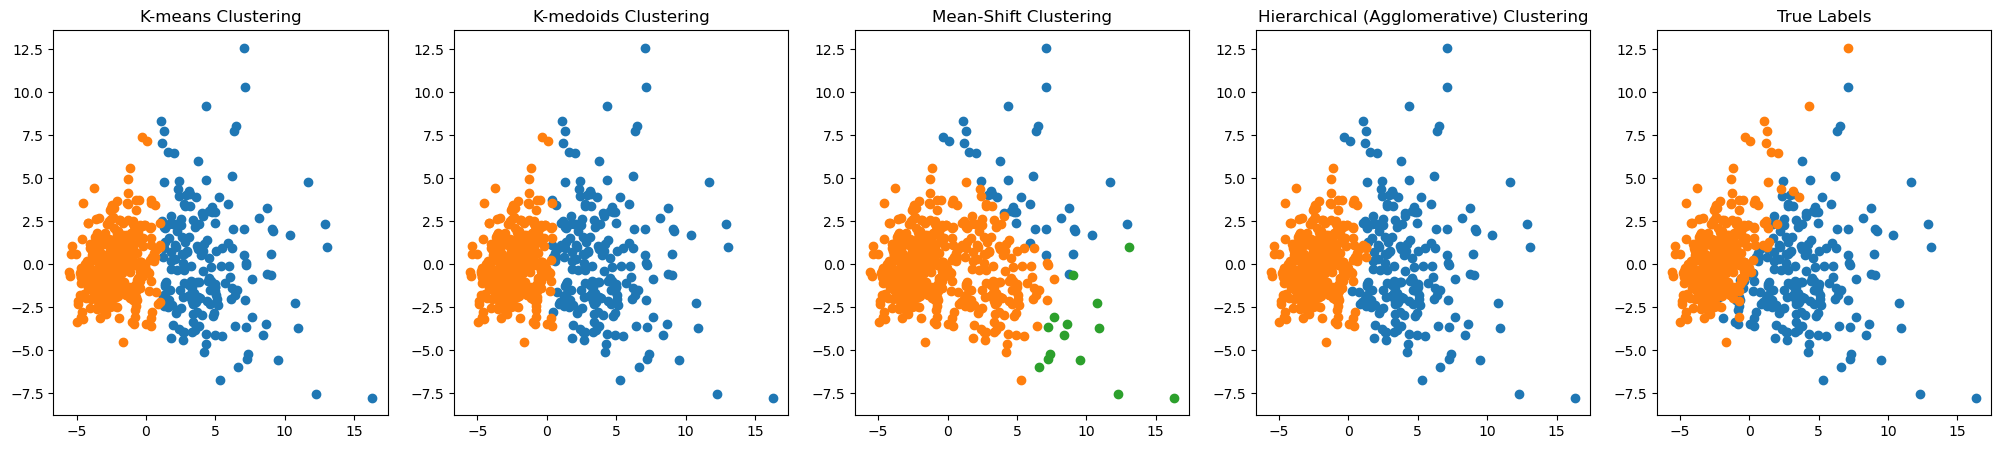

In [33]:
plt.figure(figsize=(25, 5))  # 25 = 5x5; each plot will take up 5 units.

plt.subplot(151)  # Num rows, num columns, index (write plot in index 1 of a 1x5 grid)
visualize_clustering(X_pca, kmeans_labels, title='K-means Clustering')

plt.subplot(152)
visualize_clustering(X_pca, kmedoids_labels, title='K-medoids Clustering')

plt.subplot(153)
visualize_clustering(X_pca, mean_shift_labels, title='Mean-Shift Clustering')

plt.subplot(154)
visualize_clustering(X_pca, agg_labels, title='Hierarchical (Agglomerative) Clustering')

plt.subplot(155)
visualize_clustering(X_pca, y, title='True Labels')

plt.show()

### Metrics 

In [34]:
metrics_df = pd.DataFrame(metrics_data, index=['Accuracy', 'F1-Score', 'Precision', 'Recall'])
metrics_df

,K-means,K-medoids,Mean-shift,Hierarchical
Accuracy,0.906854,0.917399,0.660808,0.906854
F1-Score,0.927891,0.934631,0.660808,0.927497
Precision,0.902116,0.928177,0.660808,0.906417
Recall,0.955182,0.941176,0.660808,0.949580


**Based on the above outputs, Are any models better than the others? Which would you choose for the data?**

*[...]*